# Different analysis / visualizations

In [1]:
import pandas as pd
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from urllib.parse import urlencode
import requests
import seaborn as sns
import unicodedata
from difflib import SequenceMatcher

In [2]:
df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')
df

/tmp/ipykernel_7032/2148436038.py:1: DtypeWarning: Columns (20,21,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')


,doi,publication_year,language,field_name_top_topic,journal,journal_id,issn_l,publisher,publisher_id,display_name_institution,...,APC price after discount,Full APC,Discount,Amount Charged,NationalAgreement,Corresponding_author_email_recon,apc_hyp_1,apc_hyp_2,euro,median
0,https://doi.org/10.1016/j.ejca.2012.12.027,2013,en,Medicine,European Journal of Cancer,S16731738,0959-8049,Elsevier BV,P4310320990,"{'National Cancer Registry', 'Piedmont Referen...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2676.26
1,https://doi.org/10.1016/j.immuni.2013.10.003,2013,en,Medicine,Immunity,S199671312,1074-7613,Cell Press,P4310315673,"{'Centre de Recherche des Cordeliers', 'Sorbon...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4487.84
2,https://doi.org/10.1016/j.jacc.2013.10.029,2013,en,Medicine,NaN,{},NaN,NaN,{},"{'Bicêtre Hospital', 'Université Paris-Sud', '...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://doi.org/10.1093/eurheartj/eht273,2013,en,Medicine,European Heart Journal,S181568219,0195-668X,Oxford University Press,P4310311648,"{'University of Milan', 'Pitié-Salpêtrière Hos...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://doi.org/10.1016/j.jbusvent.2013.07.003,2013,en,"Business, Management and Accounting",Digital Access to Libraries,S4306400166,NaN,Harris County Public Library,I2800384882,"{'UCLouvain', 'Université Lille Nord de France'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157984,https://doi.org/10.26532/jh.v40i1.37175,2024,fr,{},Jurnal Hukum,S4210234340,1412-2723,NaN,{},"{'Universitas Kristen Indonesia Paulus', 'Univ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157985,https://doi.org/10.1109/icacite60783.2024.1126...,2024,NaN,{},NaN,{},NaN,NaN,{},"{'Uttaranchal University', 'School of Business...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157986,https://doi.org/10.1055/s-0044-1791345,2024,en,{},NaN,{},NaN,NaN,{},"{""École Nationale Vétérinaire d'Alfort""}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157987,https://doi.org/10.3390/quantum1020022,2019,en,Physics and Astronomy,Quantum Reports,S4210211996,NaN,Multidisciplinary Digital Publishing Institute,P4310310987,{'Fudan University'},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Stack plot publisher

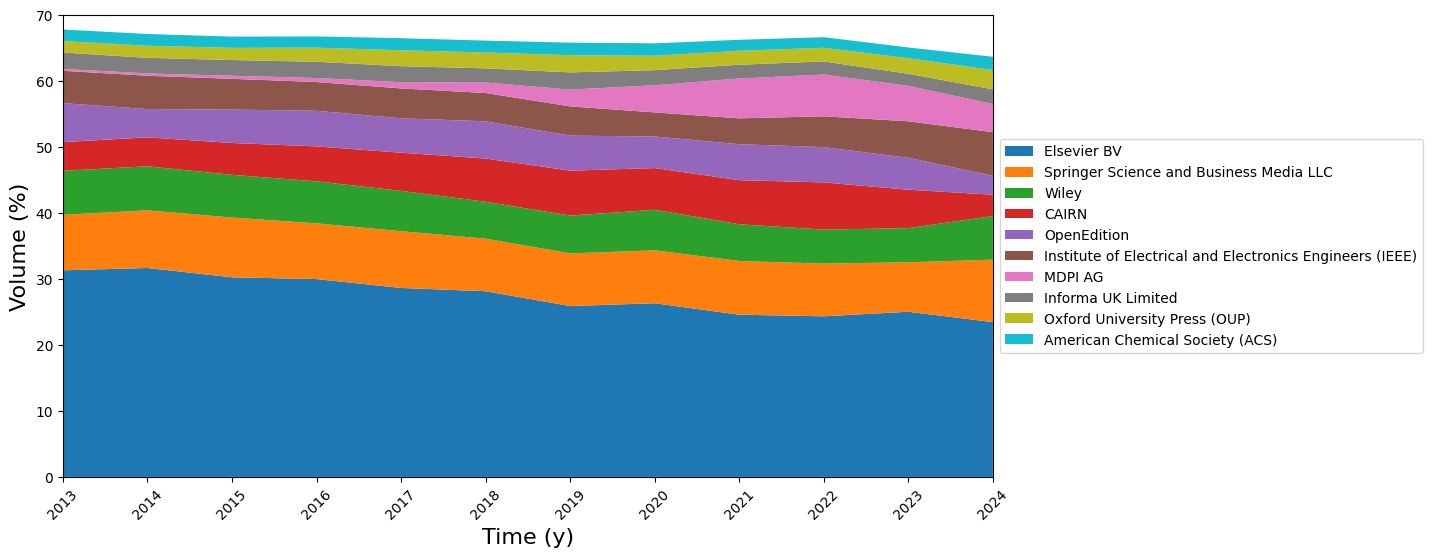

In [52]:
# df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')[['doi', 'publication_year']]
df['doi_prefix'] = df.doi.apply(lambda x: x[16::].split('/')[0])

publisher = pd.read_csv('../data/external/publisher_doi_full.csv')

df_publisher = df.merge(publisher, on = 'doi_prefix', how = 'left')

# THERE ARE 10924 DOIS (0.94% OF THEM) WITHOUT LINK

df_group = pd.read_csv('../data/external/publisher_group.csv', header = None)[1::]
df_group.columns = df_group.iloc[0]
df_group = df_group.iloc[1:].reset_index(drop=True)[['publisher_clean', 'publisher_group', 'group_start_date']]
pub_dict = df_group.set_index('publisher_clean')['publisher_group'].to_dict()
year_dict = df_group.set_index('publisher_clean')['group_start_date'].astype(int).to_dict()
mask = (df_publisher['publisher'].isin(pub_dict) & df_publisher['publisher'].isin(year_dict) & (df_publisher['publication_year'] >= df_publisher['publisher'].map(year_dict)))
df_publisher.loc[mask, 'publisher'] = df_publisher.loc[mask, 'publisher'].map(pub_dict)

top_publishers = list(df_publisher.groupby('publisher').count().sort_values('doi', ascending = False)[0:10].index)
years = sorted(df_publisher.publication_year.unique())
df_per = pd.DataFrame(index = top_publishers, columns = years)
for year in years: 
    df_publisher_year = df_publisher[df_publisher.publication_year == year]  
    for publisher in top_publishers:
        df_publisher_year_publisher = df_publisher_year[df_publisher_year.publisher == publisher]            
        df_per.at[publisher, year] = df_publisher_year_publisher.doi.nunique() / df_publisher_year.doi.nunique()

fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(df_per.columns.astype(int), df_per.values.astype(float) * 100, labels = df_per.index)
ax.set_xticks(np.arange(years[0], years[-1] + 1))
ax.set_xticklabels(np.arange(years[0], years[-1] + 1), rotation = 45)
ax.set_yticks(np.arange(0, 80, 10))
ax.set_yticklabels(np.arange(0, 80, 10))
ax.set_xlim(years[0], years[-1])
ax.set_ylim(0, 70)
ax.set_ylabel('Volume (%)', fontsize = 16)  
ax.set_xlabel('Time (y)', fontsize = 16)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


## First plots volume-fund

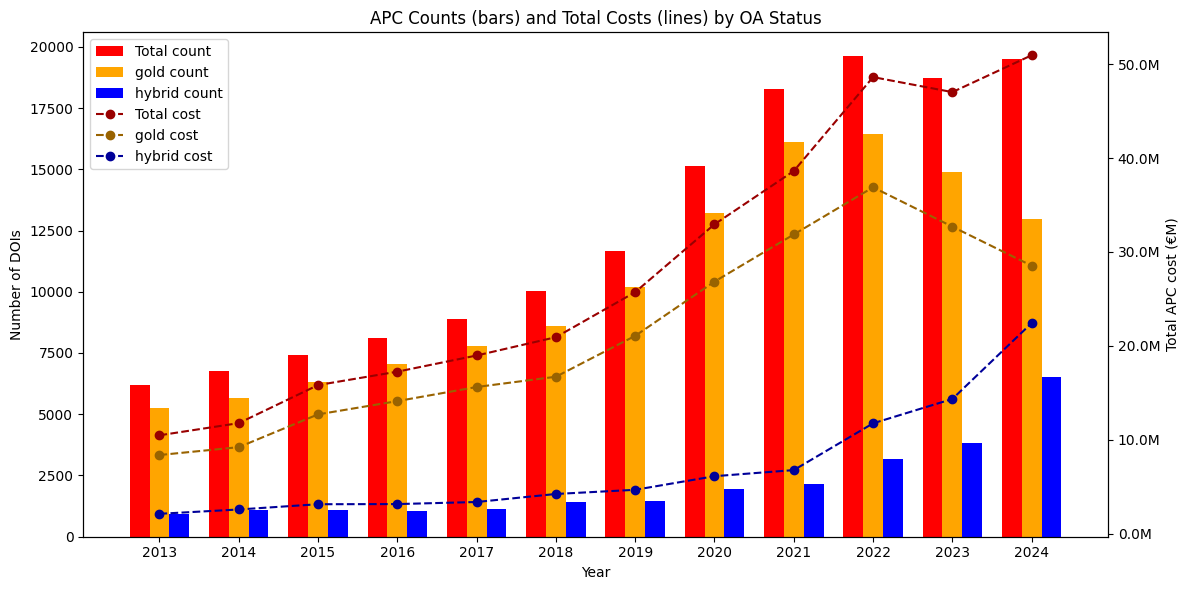

In [ ]:
### CANVIAR QUAN TINGUI EL FINAL

df = pd.read_csv('../data/interim/initial_dataset_elsevierwiliey_openapc.csv').drop(columns = 'Unnamed: 0')
df_money = pd.read_csv('EUR_USD_yearly_avg_2013_2024.csv').set_index('year')

df_apc_list = df[~df.apc_list.isna()].reset_index(drop = True)
df_apc_list['apc_list'] = df_apc_list.apc_list.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
df_apc_list['value_usd'] = df_apc_list.apc_list.apply(lambda x: x['value_usd'])
df_apc_list['value_usd_to_eur'] = df_apc_list.apply(lambda x: x['value_usd']*df_money.at[x['publication_year'], 'avg_eur_per_usd'], axis = 1)

df_apc_list_oa_gold_hyb = df_apc_list[df_apc_list.oa_status.isin(['hybrid', 'gold'])].reset_index(drop = True)
status = df_apc_list_oa_gold_hyb.groupby(['publication_year', 'oa_status']).agg({'doi':'count', 'value_usd_to_eur': 'sum'})
total = df_apc_list_oa_gold_hyb.groupby(['publication_year']).agg({'doi':'count', 'value_usd_to_eur': 'sum'})
total['oa_status'] = 'Total'
total = total.set_index('oa_status', append=True)
df_data = pd.concat([status, total]).sort_index()

bar_width = 0.25
x = np.arange(len(years))

fig, ax1 = plt.subplots(figsize=(12,6))

colors = {'gold':'orange', 'hybrid':'blue', 'Total':'red'}

# Function to darken a color
def darken_color(color, amount=0.6):
    c = mcolors.to_rgb(color)
    return (c[0]*amount, c[1]*amount, c[2]*amount)

# Plot bars for counts
for i, col in enumerate(count_df.columns):
    ax1.bar(x + i*bar_width, count_df[col], width=bar_width, color=colors.get(col,'grey'), label=f"{col} count")

ax1.set_ylabel('Number of DOIs')
ax1.set_xlabel('Year')
ax1.set_xticks(x + bar_width)  # center x-ticks under grouped bars
ax1.set_xticklabels(years)

# Right axis for cost lines
ax2 = ax1.twinx()
for col in cost_df.columns:
    dark_color = darken_color(colors.get(col,'grey'))
    ax2.plot(x + bar_width, cost_df[col], color=dark_color, marker='o', linestyle='--', label=f"{col} cost")

# Format y-axis in millions
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))

ax2.set_ylabel('Total APC cost (€M)')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('APC Counts (bars) and Total Costs (lines) by OA Status')
plt.tight_layout()
plt.show()

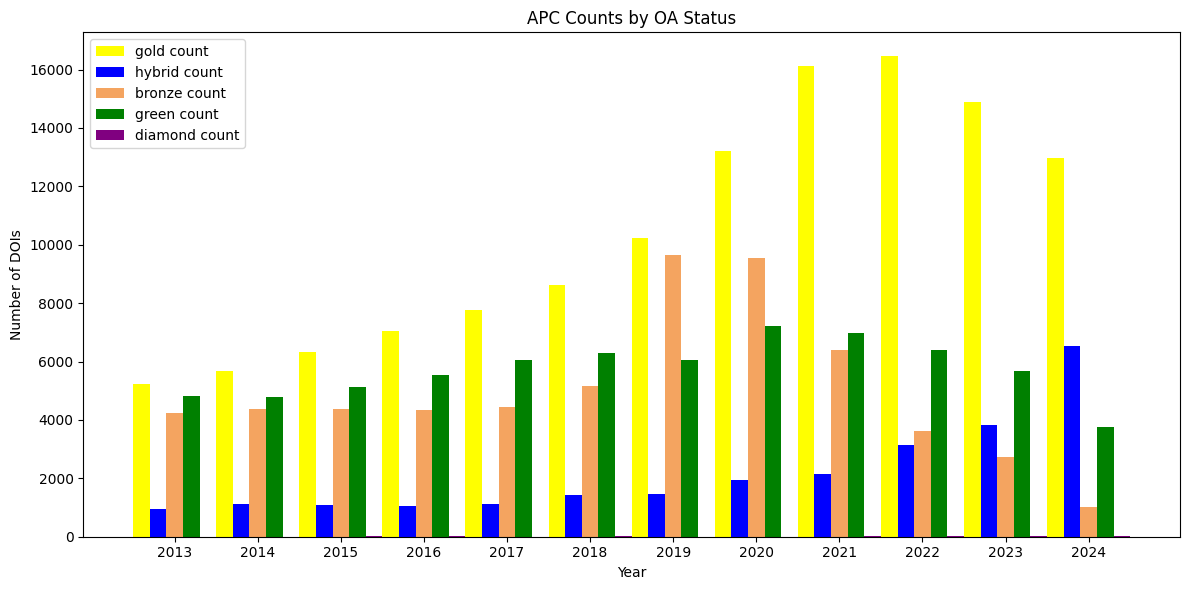

In [30]:
df_apc_list_oa = df_apc_list[df_apc_list.oa_status != 'closed'].reset_index(drop=True)

# Group and pivot counts
df_data = df_apc_list_oa.groupby(['publication_year', 'oa_status']).agg({'doi':'count'})
count_df = df_data['doi'].unstack('oa_status').fillna(0)

years = count_df.index
bar_width = 0.2
x = np.arange(len(years))

colors = {'gold':'yellow', 'hybrid':'blue', 'bronze':'sandybrown',
          'green':'green','diamond':'purple'}

desired_order = ['gold', 'hybrid', 'bronze', 'green', 'diamond']
count_df = count_df[desired_order]

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot bars for counts
for i, col in enumerate(count_df.columns):
    ax1.bar(x + i*bar_width, count_df[col], width=bar_width,
            color=colors.get(col,'grey'), label=f"{col} count")

ax1.set_ylabel('Number of DOIs')
ax1.set_xlabel('Year')
ax1.set_xticks(x + bar_width*(len(count_df.columns)-1)/2)  # center x-ticks under grouped bars
ax1.set_xticklabels(years)

# Legend
ax1.legend(loc='upper left')

plt.title('APC Counts by OA Status')
plt.tight_layout()
plt.show()

In [16]:
df[df.apc_list.isna()].groupby('oa_status').count()[['doi']] / df.groupby('oa_status').count()[['doi']]

,doi
oa_status,
bronze,0.521987
closed,0.536831
diamond,0.998787
gold,0.103610
green,0.538264
hybrid,0.570123


## First-Last author primary topic distribution

**Elsevier**

In [ ]:
col = 'Publication VoR date'
df_elsevier = pd.read_csv('../data/external/Elsevier_EOAP_2225_Décembre.csv').dropna(subset = [col, 'Article DOI'])
df_elsevier['year'] = df_elsevier[col].apply(lambda x: int(x.split('/')[-1]))
df_elsevier = df_elsevier[(df_elsevier.year <= 2023)].reset_index(drop = True)
elsevier_doi = df_elsevier['Article DOI'].str.lower().unique().tolist()

BASE_URL = "https://api.openalex.org/works"

selected_fields = ["doi", "publication_year", "language", "indexed_in", "primary_location", "best_oa_location", "open_access", "authorships", 
                   "corresponding_author_ids", "corresponding_institution_ids", "apc_list", "apc_paid", "cited_by_count", "primary_topic", "awards", "funders"]


def fetch_by_ids(id_list):
    # Normalize IDs to a string separated by |
    doi_filter = "doi:" + "|".join(id_list)

    filters = [
        doi_filter,
        "indexed_in:crossref",
        "type:article|review",
    ]

    params = {
        "filter": ",".join(filters),
        "select": ",".join(selected_fields),
        "per_page": 200
    }

    url = f"{BASE_URL}?{urlencode(params)}"
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        data = r.json()
        return data.get("results", [])
    except requests.exceptions.JSONDecodeError:
        print("JSON decode error for URL:", url[:200])
        pass
    except requests.exceptions.RequestException as e:
        print("Request error:", e)
        pass

batch_size = 50  # try increasing, test carefully
all_fetched_els = []
for i in tqdm(range(0, len(elsevier_doi), batch_size)):
    batch = elsevier_doi[i:i+batch_size]
    results = fetch_by_ids(batch)
    all_fetched_els.extend(results)

    
all_fetched_els_df = pd.json_normalize(all_fetched_els)
all_fetched_els_df

,doi,publication_year,language,indexed_in,authorships,corresponding_author_ids,corresponding_institution_ids,cited_by_count,awards,funders,...,primary_topic.subfield.display_name,primary_topic.field.id,primary_topic.field.display_name,primary_topic.domain.id,primary_topic.domain.display_name,apc_paid,best_oa_location,primary_topic,apc_list,best_oa_location.source
0,https://doi.org/10.1016/j.cscee.2023.100315,2023,en,"[crossref, doaj]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5051466818],[],16,[],[],...,Virology,https://openalex.org/fields/24,Immunology and Microbiology,https://openalex.org/domains/1,Life Sciences,NaN,NaN,NaN,NaN,NaN
1,https://doi.org/10.1016/j.ajoc.2022.101281,2022,en,"[crossref, doaj, pubmed]","[{'author_position': 'first', 'author': {'id':...",[],[],13,[],[],...,Ophthalmology,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
2,https://doi.org/10.1016/j.mycmed.2022.101325,2022,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5022958322],"[https://openalex.org/I1294671590, https://ope...",13,[],[],...,Hematology,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
3,https://doi.org/10.1016/j.ajoc.2022.101588,2022,en,"[crossref, doaj, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5038584012],[https://openalex.org/I4210129146],11,[],[],...,"Radiology, Nuclear Medicine and Imaging",https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
4,https://doi.org/10.1016/j.cscm.2023.e02764,2023,en,"[crossref, doaj]","[{'author_position': 'first', 'author': {'id':...",[],[],10,[],[],...,Civil and Structural Engineering,https://openalex.org/fields/22,Engineering,https://openalex.org/domains/3,Physical Sciences,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14857,https://doi.org/10.1016/j.mmm.2022.08.005,2022,fr,[crossref],"[{'author_position': 'first', 'author': {'id':...",[],[],0,[],"[{'id': 'https://openalex.org/F4320318638', 'd...",...,Nutrition and Dietetics,https://openalex.org/fields/29,Nursing,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
14858,https://doi.org/10.1016/j.therap.2022.09.008,2022,fr,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5058258538],"[https://openalex.org/I3019448017, https://ope...",0,[],"[{'id': 'https://openalex.org/F4320320883', 'd...",...,General Health Professions,https://openalex.org/fields/36,Health Professions,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
14859,https://doi.org/10.1016/j.lpm.2023.104165,2023,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5050789021],"[https://openalex.org/I100532134, https://open...",0,[],"[{'id': 'https://openalex.org/F4320320883', 'd...",...,Emergency Medicine,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
14860,https://doi.org/10.1016/j.mmm.2023.03.012,2023,fr,[crossref],"[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5014371425],"[https://openalex.org/I154526488, https://open...",0,[],"[{'id': 'https://openalex.org/F4320320883', 'd...",...,Epidemiology,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN


**Wiley**

In [13]:
col = 'Request Date'
df_willey = pd.read_csv('../data/external/Wiley_2225_Novembre.csv').dropna(subset = [col, 'DOI'])
df_willey['year'] = df_willey[col].apply(lambda x: int(x.split('-')[-1]))
df_willey = df_willey[(df_willey.year <= 2023)].reset_index(drop = True)
willey_doi = df_willey['DOI'].str.lower().unique().tolist()

BASE_URL = "https://api.openalex.org/works"

selected_fields = ["doi", "publication_year", "language", "indexed_in", "primary_location", "best_oa_location", "open_access", "authorships", 
                   "corresponding_author_ids", "corresponding_institution_ids", "apc_list", "apc_paid", "cited_by_count", "primary_topic", "awards", "funders"]


def fetch_by_ids(id_list):
    # Normalize IDs to a string separated by |
    doi_filter = "doi:" + "|".join(id_list)

    filters = [
        doi_filter,
        "indexed_in:crossref",
        "type:article|review",
    ]

    params = {
        "filter": ",".join(filters),
        "select": ",".join(selected_fields),
        "per_page": 200
    }

    url = f"{BASE_URL}?{urlencode(params)}"
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        data = r.json()
        return data.get("results", [])
    except requests.exceptions.JSONDecodeError:
        print("JSON decode error for URL:", url[:200])
        pass
    except requests.exceptions.RequestException as e:
        print("Request error:", e)
        pass

batch_size = 50  # try increasing, test carefully
all_fetched_wil = []
for i in tqdm(range(0, len(willey_doi), batch_size)):
    batch = willey_doi[i:i+batch_size]
    results = fetch_by_ids(batch)
    all_fetched_wil.extend(results)

    
all_fetched_wil_df = pd.json_normalize(all_fetched_wil)
all_fetched_wil_df

100%|██████████| 82/82 [01:06<00:00,  1.22it/s]


,doi,publication_year,language,indexed_in,authorships,corresponding_author_ids,corresponding_institution_ids,cited_by_count,awards,funders,...,primary_topic.score,primary_topic.subfield.id,primary_topic.subfield.display_name,primary_topic.field.id,primary_topic.field.display_name,primary_topic.domain.id,primary_topic.domain.display_name,apc_paid,apc_list,best_oa_location
0,https://doi.org/10.1111/all.15996,2023,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5042448793],"[https://openalex.org/I154526488, https://open...",99,"[{'id': 'https://openalex.org/G227127304', 'di...","[{'id': 'https://openalex.org/F4320327298', 'd...",...,1.0000,https://openalex.org/subfields/2736,Pharmacology,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN
1,https://doi.org/10.1111/imr.13304,2024,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...","[https://openalex.org/A5047928635, https://ope...","[https://openalex.org/I1344073410, https://ope...",42,"[{'id': 'https://openalex.org/G6942009027', 'd...","[{'id': 'https://openalex.org/F4320308273', 'd...",...,0.9993,https://openalex.org/subfields/2712,"Endocrinology, Diabetes and Metabolism",https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN
2,https://doi.org/10.1002/adma.202311437,2024,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...","[https://openalex.org/A5048325281, https://ope...","[https://openalex.org/I100532134, https://open...",39,"[{'id': 'https://openalex.org/G4912847769', 'd...","[{'id': 'https://openalex.org/F4320320883', 'd...",...,0.9938,https://openalex.org/subfields/1312,Molecular Biology,https://openalex.org/fields/13,"Biochemistry, Genetics and Molecular Biology",https://openalex.org/domains/1,Life Sciences,NaN,NaN,NaN
3,https://doi.org/10.1111/den.14750,2024,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5084996644],"[https://openalex.org/I19894307, https://opena...",25,[],[],...,1.0000,https://openalex.org/subfields/2740,Pulmonary and Respiratory Medicine,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN
4,https://doi.org/10.1111/gcb.17105,2024,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5087915271],"[https://openalex.org/I1294671590, https://ope...",24,"[{'id': 'https://openalex.org/G2700155966', 'd...","[{'id': 'https://openalex.org/F4320309024', 'd...",...,0.9999,https://openalex.org/subfields/1910,Oceanography,https://openalex.org/fields/19,Earth and Planetary Sciences,https://openalex.org/domains/3,Physical Sciences,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,https://doi.org/10.1111/ejh.13778,2022,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5016078623],[https://openalex.org/I4210100596],9,[],"[{'id': 'https://openalex.org/F4320323878', 'd...",...,0.9998,https://openalex.org/subfields/2720,Hematology,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN
3933,https://doi.org/10.1111/hae.14579,2022,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5066873761],"[https://openalex.org/I195731000, https://open...",8,[],[],...,0.9994,https://openalex.org/subfields/2740,Pulmonary and Respiratory Medicine,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN
3934,https://doi.org/10.1002/chem.202200734,2022,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...","[https://openalex.org/A5020464045, https://ope...","[https://openalex.org/I1294671590, https://ope...",5,"[{'id': 'https://openalex.org/G5468993288', 'd...","[{'id': 'https://openalex.org/F4320320883', 'd..."

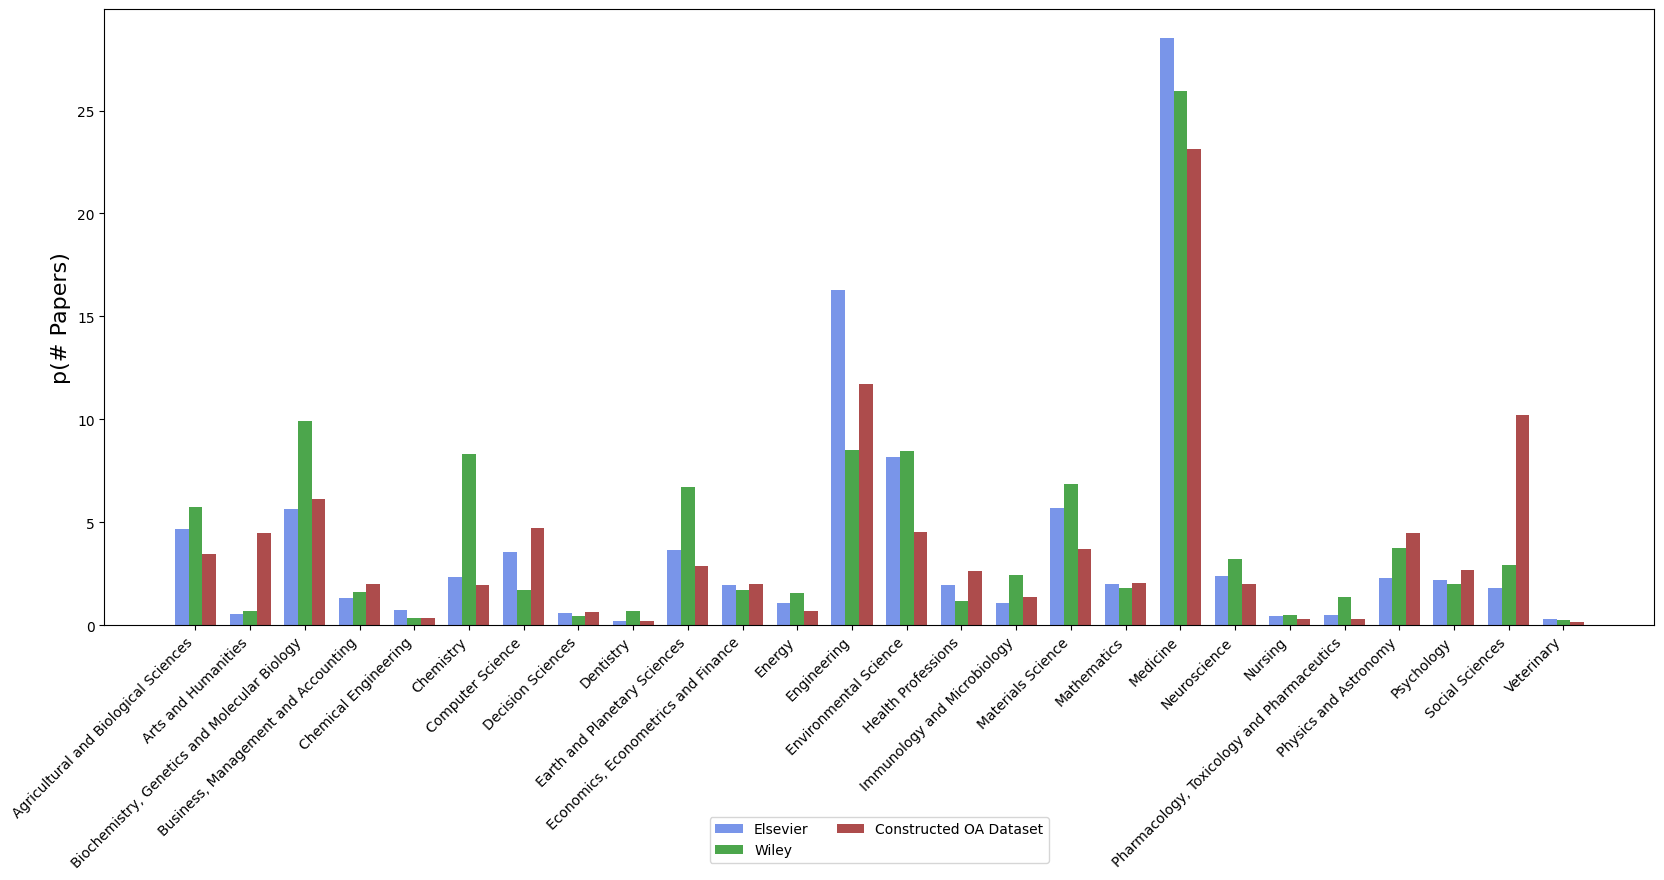

In [ ]:
df_tmp = all_fetched_els_df.merge(df_elsevier[['Article DOI', 'Corresponding author name']], left_on = all_fetched_els_df.doi.apply(lambda x: x[16::].lower()), right_on = df_elsevier['Article DOI'].str.lower(), how = 'inner')[['doi', 'primary_topic.field.display_name']]
grouped_els = df_tmp.groupby(['primary_topic.field.display_name']).count()[['doi']].rename(columns={'doi': 'elsevier'}) / df_tmp.doi.nunique() * 100

df_tmp = all_fetched_wil_df.merge(df_willey[['DOI', 'Responsible Corresponding author']], left_on = all_fetched_wil_df.doi.apply(lambda x: x[16::].lower()), right_on = df_willey['DOI'].str.lower(), how = 'inner')[['doi', 'primary_topic.field.display_name']]
grouped_wils = df_tmp.groupby(['primary_topic.field.display_name']).count()[['doi']].rename(columns={'doi': 'wiley'}) / df_tmp.doi.nunique() * 100

df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')# .drop(columns = 'Unnamed: 0')
df_years = df[(df.publication_year >= 2020) & (df.publication_year <= 2023)]

grouped_oa = df_years.groupby(['field_name_top_topic']).count()[['doi']].rename(columns={'doi': 'oa'}) / df_years.doi.nunique() * 100

df_tmp_1 = grouped_els.merge(grouped_oa, left_index = True, right_index = True, how = 'inner')
df_tmp_1 = grouped_wils.merge(df_tmp_1, left_index = True, right_index = True, how = 'inner')

fig, axs = plt.subplots(1, 1, figsize=(20, 8))
fig.subplots_adjust(hspace=0.4)

width = 0.25
offsets = [-width, 0, width]

x_positions = np.arange(len(df_tmp_1.index))

axs.bar(x_positions + offsets[0], df_tmp_1.elsevier, width, color='royalblue', alpha=0.7, label='Elsevier')
axs.bar(x_positions + offsets[1], df_tmp_1.wiley, width, color='green', alpha=0.7, label='Wiley')
axs.bar(x_positions + offsets[2], df_tmp_1.oa, width, color='darkred', alpha=0.7, label='Constructed OA Dataset')

axs.set_ylabel('p(# Papers)', fontsize = 16)
axs.set_xticks(x_positions)
axs.set_xticklabels([f"{name}" for name in df_tmp_1.index], rotation=45, ha='right')

axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)


### Others

In [77]:
df_apc_paid = df[~df.euro.isna()].reset_index(drop = True)
df_apc_paid['apc_paid'] = df_apc_paid.apc_paid.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
df_apc_paid['value_usd'] = df_apc_paid['apc_paid'].apply(
    lambda x: x.get('value_usd') if isinstance(x, dict) else None
)
df_apc_paid['value_usd_to_eur'] = df_apc_paid.apply(lambda x: x['value_usd']*df_money.at[x['publication_year'], 'avg_eur_per_usd'], axis = 1)

print((df_apc_paid['value_usd_to_eur'] - df_apc_paid['euro']).mean())
print((df_apc_paid['value_usd_to_eur'] - df_apc_paid['euro']).std())

-64.00829028589632
188.63878292925216


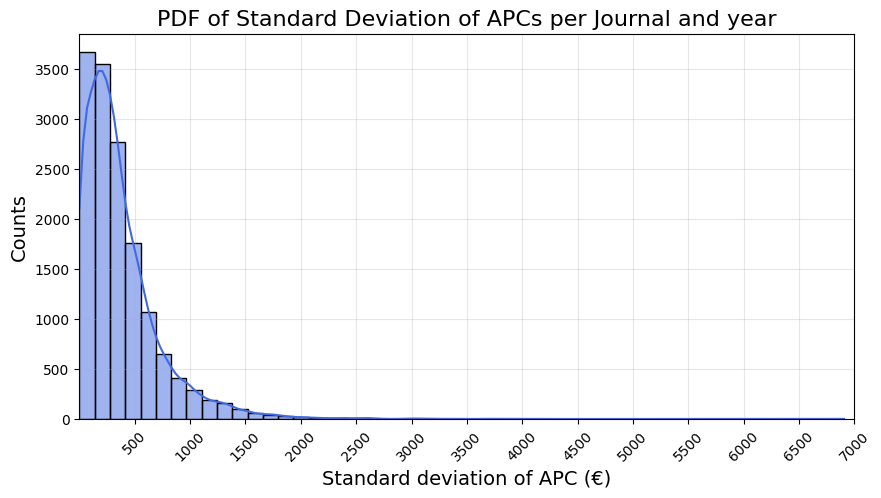

In [ ]:
interest_cols = ['doi', 'euro', 'issn_l', 'period']
df_open_apc = pd.read_csv('../data/external/apc_de.csv')[interest_cols]

df_interest = pd.read_csv('../data/interim/initial_dataset_elsevierwiliey.csv')

df_tmp = df_interest.merge(df_open_apc.rename(columns={'doi': 'doi_apc'}), left_on = 'doi_corr', right_on = 'doi_apc', how = 'left')
df_tmp = df_tmp.drop(columns=['doi_apc', 'period']).rename(columns={'doi_x': 'doi'})

valid_issns = df_tmp['issn_l_y'].dropna().unique()
median_apc = (df_open_apc[df_open_apc['issn_l'].isin(valid_issns)].groupby(['issn_l', 'period'])['euro'].median())
counts = (df_open_apc[df_open_apc['issn_l'].isin(df_tmp['issn_l_y'].dropna().unique())].groupby(['issn_l', 'period'])['euro'].count())

df_tmp['median'] = pd.Series(list(zip(df_tmp['issn_l_x'], df_tmp['publication_year']))).map(median_apc)
df_tmp = df_tmp.drop(columns=['issn_l_y']).rename(columns={'issn_l_x': 'issn_l'})

std_apc = (df_open_apc[df_open_apc['issn_l'].isin(valid_issns)].groupby(['issn_l', 'period'])['euro'].std())

std_values = std_apc.dropna()

plt.figure(figsize=(10, 5))
sns.histplot(std_values, bins=50, kde=True, color='royalblue')  # KDE adds a smooth PDF

plt.xlabel('Standard deviation of APC (€)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xlim(0, 7e3)
xticks = np.arange(500, int(std_values.max()) + 500, 500)
plt.xticks(xticks, labels=[str(int(x)) for x in xticks], rotation=45)
plt.title('PDF of Standard Deviation of APCs per Journal and year', fontsize=16)
plt.grid(alpha=0.3)
plt.show()

### National Agreement author disambiguation

In [ ]:
df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')
df_na = df[df.NationalAgreement.notna()].reset_index(drop = True)[['doi', 'display_name_author', 'countries']] # [['doi', 'display_name_author', 'corresponding', 'Corresponding_author_email_recon', 'countries']]

df_na['display_name_author'] = df_na.display_name_author.apply(lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else [])
df_na['countries'] = df_na.countries.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})


df_na['display_name_author_fr'] = df_na.apply(lambda x: [author for author, coun in zip(x['display_name_author'], x['countries']) if any('FR' == c for c in coun)], axis = 1)

df_na_tmp = df_na.drop(columns = ['countries']).explode('display_name_author_fr').reset_index(drop = True)
df_na_tmp = df_na_tmp[df_na_tmp['display_name_author_fr'].notna() & df_na_tmp['display_name_author_fr'].str.strip().astype(bool)]
df_na_tmp['display_name_author_fr_utf8']  = df_na_tmp.display_name_author_fr.apply(lambda x: unicodedata.normalize('NFKD', x.lower()).encode('ascii', 'ignore').decode('ascii'))
df_na_tmp.drop(columns = 'display_name_author').drop_duplicates('display_name_author_fr_utf8').sort_values('display_name_author_fr_utf8').reset_index(drop = True).to_csv('na_fr_authors.csv')


df_na

,doi,display_name_author,countries,display_name_author_fr
0,https://doi.org/10.1002/jbmr.4616,"[Anaïs Julien, Simon Perrin, Ester Martínez‐Sa...","[[FR], [FR], [FR], [FR], [FR], [FR], [FR], [FR]]","[Anaïs Julien, Simon Perrin, Ester Martínez‐Sa..."
1,https://doi.org/10.1002/jbmr.4720,"[Thierry Thomas, Florence Tubach, Geoffray Biz...","[[FR], [FR], [FR], [BE], [FR], [BE], [FR], [],...","[Thierry Thomas, Florence Tubach, Geoffray Biz..."
2,https://doi.org/10.1002/jbmr.4792,"[Benoît Gobron, Malory Couchot, Nigel Irwin, É...","[[FR], [FR], [GB], [FR], [FR], [FR]]","[Benoît Gobron, Malory Couchot, Érick Legrand,..."
3,https://doi.org/10.1016/j.mam.2021.101044,"[Marco Cecchini, Jean‐Pierre Changeux]","[[FR], [FR, US]]","[Marco Cecchini, Jean‐Pierre Changeux]"
4,https://doi.org/10.1016/j.actbio.2021.11.046,"[Sophie Maillard, Ludovic Sicard, Caroline And...","[[FR], [FR], [FR], [FR], [FR], [FR], [FR], [FR...","[Sophie Maillard, Ludovic Sicard, Caroline And..."
...,...,...,...,...
12093,https://doi.org/10.1016/j.ijheatmasstransfer.2...,"[Gaël Poëtte, Augustin de la Vauvre, Gérard L....","[[FR], [FR], [FR]]","[Gaël Poëtte, Augustin de la Vauvre, Gérard L...."
12094,https://doi.org/10.1016/j.fuel.2024.134033,"[C. Maudet, X. Ji, Essyllt Louarn, Fabienne Fa...","[[FR], [FR], [FR], [FR], [FR], [FR], [FR], [FR]]","[C. Maudet, X. Ji, Essyllt Louarn, Fabienne Fa..."
12095,https://doi.org/10.1016/j.jconrel.2024.12.050,"[Soizic Martin-Aubert, Kevin Avrillon, Nicolas...","[[FR], [FR], [FR], [FR], [FR], [FR], [FR], [FR...","[Soizic Martin-Aubert, Kevin Avrillon, Nicolas..."
12096,https://doi.org/10.1016/j.jhevol.2024.103631,"[Juliette Henrion, Bruno Maureille, Cédric Bea...","[[FR], [FR], [], [FR], [DE, FR], [FR]]","[Juliette Henrion, Bruno Maureille, Nicolas Va..."


**Manually reconcile using Open Refine**

In [7]:
def closest_match_with_score(name, choices):
    if not isinstance(name, str):
        return (None, 0.0)
    if not isinstance(choices, list):
        return (None, 0.0)
    choices = [c for c in choices if isinstance(c, str) and c.strip()]
    if not choices:
        return (None, 0.0)
    scores = [(c, SequenceMatcher(None, name, c).ratio()) for c in choices]
    best_match, best_score = max(scores, key=lambda x: x[1])
    return best_match, best_score

recon = pd.read_csv('na_fr_authors-recon.csv')
df_na_tmp_1 = df_na_tmp.merge(recon[['display_name_author_fr_utf8', 'display_name_author_fr_utf8_recon']], on = 'display_name_author_fr_utf8', how = 'left')
df_na_tmp_1 = df_na_tmp_1.merge(df[['doi', 'Corresponding_author_email_recon']], on = 'doi', how = 'left')
grouped = df_na_tmp_1.groupby(['doi', 'Corresponding_author_email_recon'])['display_name_author_fr_utf8_recon'].agg(list).reset_index()

grouped['Corresponding_author_email_recon_name'] = grouped.Corresponding_author_email_recon.apply(lambda x: x.split('@')[0].lower() if isinstance(x, str) else None)
grouped[['Proposed_corr', 'Similarity']] = grouped.apply(lambda x: pd.Series(closest_match_with_score(x['Corresponding_author_email_recon_name'],x['display_name_author_fr_utf8_recon'])), axis = 1)
grouped.sort_values(['Similarity', 'Corresponding_author_email_recon_name']).to_csv('mail_author_v2.csv')
grouped

,doi,Corresponding_author_email_recon,display_name_author_fr_utf8_recon,Corresponding_author_email_recon_name,Proposed_corr,Similarity
0,https://doi.org/10.1002/1873-3468.14360,mickael.blaise@umontpellier.fr,"[husam m. a. b. alsarraf, kien lam ung, nan, j...",mickael.blaise,mickael blaise,0.928571
1,https://doi.org/10.1002/1873-3468.14403,sophie.quevillon-cheruel@i2bc.paris-saclay.fr,"[claire cargemel, helene walbott, d. durand, p...",sophie.quevillon-cheruel,sophie quevilloncheruel,0.936170
2,https://doi.org/10.1002/1873-3468.14465,xavier.coumoul@parisdescartes.fr,"[kevin bernal, charbel touma, chedi erradhouan...",xavier.coumoul,xavier coumoul,0.928571
3,https://doi.org/10.1002/1873-3468.14507,nghe.espci@gmail.com,"[polina pavlinova, camille n. lambert, philipp...",nghe.espci,philippe nghe,0.347826
4,https://doi.org/10.1002/1873-3468.14565,tmignot@imm.cnrs.fr,"[celine dinet, tam mignot]",tmignot,tam mignot,0.823529
...,...,...,...,...,...,...
11805,https://doi.org/10.3168/jds.2024-25113,rachel.rupp@inra.fr,"[m wicki, thierry fassier, christophe huau, fa...",rachel.rupp,rachel rupp,0.909091
11806,https://doi.org/10.3168/jds.2024-25127,coralie.machefert@inrae.fr,"[c. machefert, christele robert-granie, jeanmi...",coralie.machefert,c. machefert,0.758621
11807,https://doi.org/10.3168/jds.2024-25168,aurelie.vinet@inrae.fr,"[aurelie vinet, corentin fouere, beatriz c. d....",aurelie.vinet,aurelie vinet,0.923077
11808,https://doi.org/10.3168/jds.2024-25209,charlotte.gaillard@agrsci.dk,"[charlotte gaillard, justine abarnou]",charlotte.gaillard,charlotte gaillard,0.944444


**Using institutions**

In [2]:
def closest_match_with_score(name, choices):
    if not isinstance(name, str):
        return (None, 0.0)
    if not isinstance(choices, list):
        return (None, 0.0)
    choices = [c for c in choices if isinstance(c, str) and c.strip()]
    if not choices:
        return (None, 0.0)
    scores = [(c, SequenceMatcher(None, name, c).ratio()) for c in choices]
    best_match, best_score = max(scores, key=lambda x: x[1])
    return best_match, best_score

df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')
df_na = df[df.NationalAgreement.notna()].reset_index(drop = True)[['doi', 'display_name_institution', 'countries']] # [['doi', 'display_name_author', 'corresponding', 'Corresponding_author_email_recon', 'countries']]

df_na['display_name_institution'] = df_na.display_name_institution.apply(lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else [])
df_na['countries'] = df_na.countries.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})


df_na['display_name_institution_fr'] = df_na.apply(lambda x: [author for author, coun in zip(x['display_name_institution'], x['countries']) if any('FR' == c for c in coun)], axis = 1)

df_na_tmp = df_na.drop(columns = ['countries']).explode('display_name_institution_fr').reset_index(drop = True)
df_na_tmp = df_na_tmp[df_na_tmp['display_name_institution_fr'].notna() & df_na_tmp['display_name_institution_fr'].str.strip().astype(bool)]
df_na_tmp['display_name_institution_fr_utf8']  = df_na_tmp.display_name_institution_fr.apply(lambda x: unicodedata.normalize('NFKD', x.lower()).encode('ascii', 'ignore').decode('ascii'))
df_na_tmp_1 = df_na_tmp.merge(df[['doi', 'Corresponding_author_email_recon']], on = 'doi', how = 'left')
grouped = df_na_tmp_1.groupby(['doi', 'Corresponding_author_email_recon'])['display_name_institution_fr_utf8'].agg(list).reset_index()
grouped['Corresponding_institution_email_recon_name'] = grouped.Corresponding_author_email_recon.apply(lambda x: x.split('@')[1].lower() if isinstance(x, str) else None)
grouped[['Proposed_corr', 'Similarity']] = grouped.apply(lambda x: pd.Series(closest_match_with_score(x['Corresponding_institution_email_recon_name'],x['display_name_institution_fr_utf8'])), axis = 1)
grouped


/tmp/ipykernel_5303/1379013977.py:13: DtypeWarning: Columns (20,21,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')


,doi,Corresponding_author_email_recon,display_name_institution_fr_utf8,Corresponding_institution_email_recon_name,Proposed_corr,Similarity
0,https://doi.org/10.1002/1873-3468.14360,mickael.blaise@umontpellier.fr,"[aarhus university, institut de recherche en i...",umontpellier.fr,institut de recherche en infectiologie de mont...,0.352941
1,https://doi.org/10.1002/1873-3468.14403,sophie.quevillon-cheruel@i2bc.paris-saclay.fr,"[cea paris-saclay, centre national de la reche...",i2bc.paris-saclay.fr,cea paris-saclay,0.722222
2,https://doi.org/10.1002/1873-3468.14465,xavier.coumoul@parisdescartes.fr,"[inserm, universite paris cite, inserm, ecole ...",parisdescartes.fr,universite paris cite,0.421053
3,https://doi.org/10.1002/1873-3468.14507,nghe.espci@gmail.com,"[chimie biologie innovation, centre national d...",gmail.com,chimie biologie innovation,0.228571
4,https://doi.org/10.1002/1873-3468.14565,tmignot@imm.cnrs.fr,"[aix-marseille universite, centre national de ...",imm.cnrs.fr,aix-marseille universite,0.285714
...,...,...,...,...,...,...
11786,https://doi.org/10.3168/jds.2024-25113,rachel.rupp@inra.fr,"[genetique physiologie et systemes d'elevage, ...",inra.fr,institut de lelevage,0.222222
11787,https://doi.org/10.3168/jds.2024-25127,coralie.machefert@inrae.fr,"[genetique physiologie et systemes d'elevage, ...",inrae.fr,universite federale de toulouse midi-pyrenees,0.188679
11788,https://doi.org/10.3168/jds.2024-25168,aurelie.vinet@inrae.fr,"[agroparistech, institut national de recherche...",inrae.fr,universite paris-saclay,0.258065
11789,https://doi.org/10.3168/jds.2024-25209,charlotte.gaillard@agrsci.dk,[institut national de recherche pour l'agricul...,agrsci.dk,institut national de recherche pour l'agricult...,0.107527


/tmp/ipykernel_16122/478637444.py:23: DtypeWarning: Columns (20,21,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')


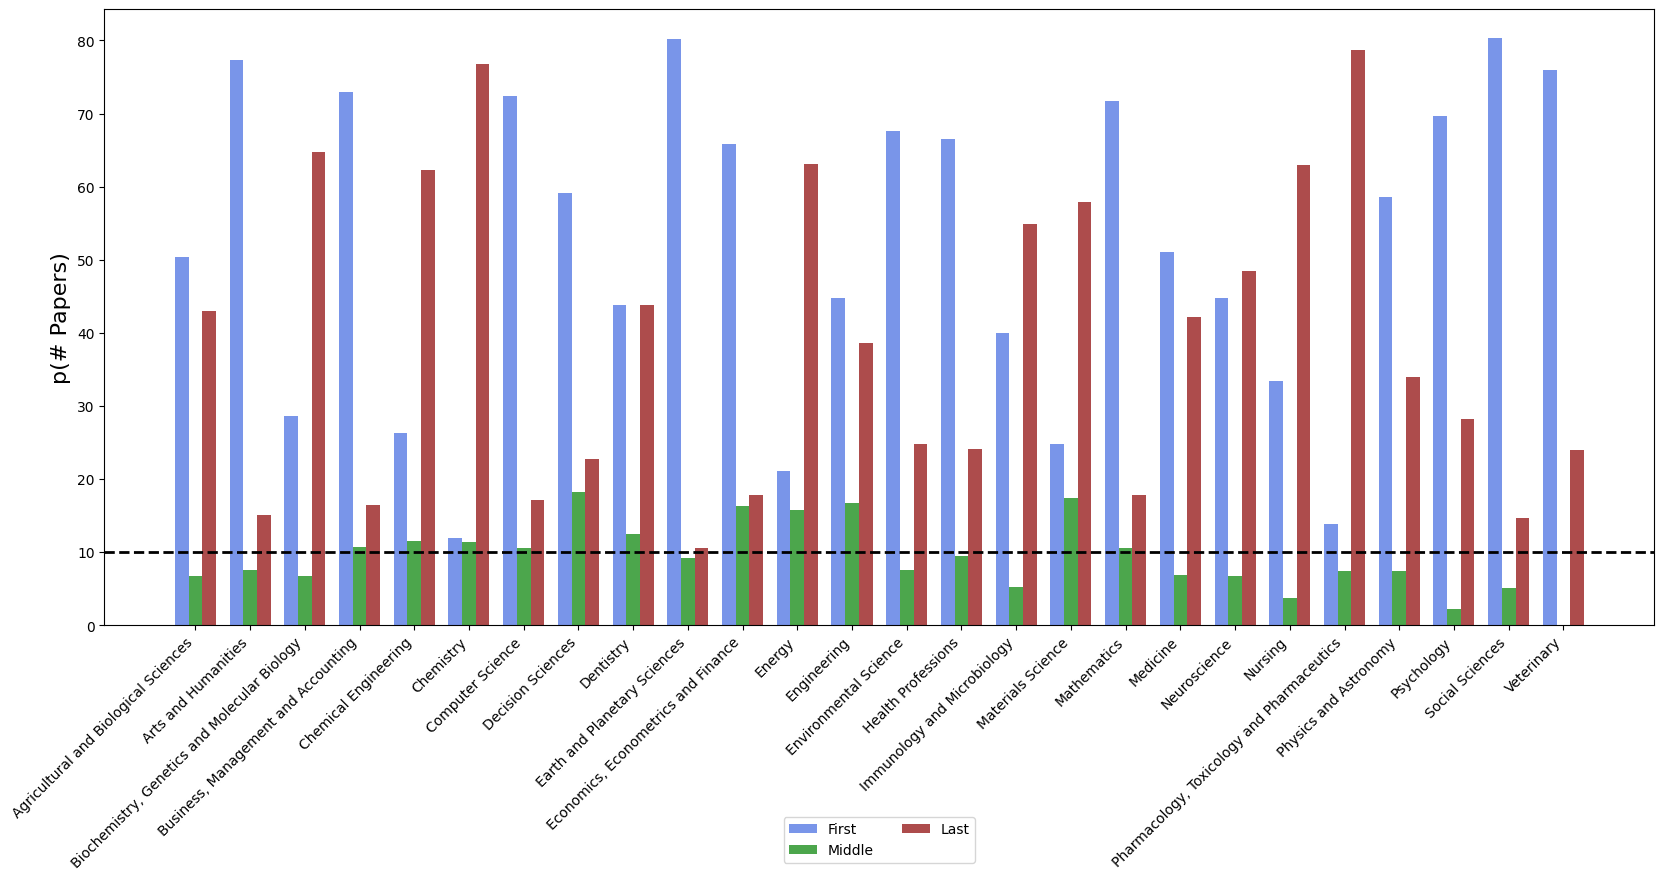

In [2]:
def closest_match_position(name, choices):
    if not isinstance(name, str) or not isinstance(choices, list):
        return None
    best_idx = None
    best_score = -1.0
    for i, c in enumerate(choices):
        if not isinstance(c, str) or not c.strip():
            continue
        score = SequenceMatcher(None, name, c).ratio()
        if score > best_score:
            best_score = score
            best_idx = i
    return best_idx

def auth_pos(x):
    if x['position'] == 0:
        return 'first'
    if x['position'] == x['len'] - 1:
        return 'last'
    else:
        return 'middle'

df = pd.read_csv('../data/processed/initial_dataset_elsevierwiliey_openapc.csv')
df_recon = pd.read_csv('Miscellaneous - Author_Mail_v2.csv')
df_tmp = df[['doi', 'field_name_top_topic', 'display_name_author']].merge(df_recon, on = 'doi').dropna().reset_index(drop = True)
df_tmp['display_name_author'] = df_tmp.display_name_author.apply(lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else [])
df_tmp['position'] = df_tmp.apply(lambda x: closest_match_position(x['corrected author'], x['display_name_author']), axis = 1)
df_tmp['len'] = df_tmp.display_name_author.apply(lambda x: len(x))
df_tmp['interest'] = df_tmp.apply(lambda x: auth_pos(x), axis = 1)

pivot = df_tmp.pivot_table(index = 'field_name_top_topic', columns = 'interest', values = df_tmp.columns[0], aggfunc = 'count', fill_value = 0)
pivot_norm = pivot.div(pivot.sum(axis = 1), axis=0) * 100

fig, axs = plt.subplots(1, 1, figsize=(20, 8))
fig.subplots_adjust(hspace=0.4)

width = 0.25
offsets = [-width, 0, width]

x_positions = np.arange(len(pivot_norm.index))

axs.bar(x_positions + offsets[0], pivot_norm['first'], width, color='royalblue', alpha=0.7, label='First')
axs.bar(x_positions + offsets[1], pivot_norm['middle'], width, color='green', alpha=0.7, label='Middle')
axs.bar(x_positions + offsets[2], pivot_norm['last'], width, color='darkred', alpha=0.7, label='Last')
axs.axhline(y=10, color='black', linestyle='--', linewidth=2)

axs.set_ylabel('p(# Papers)', fontsize = 16)
axs.set_xticks(x_positions)
axs.set_xticklabels([f"{name}" for name in pivot_norm.index], rotation=45, ha='right')

axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)
